# Importing Libraries

In [ ]:

# 1. IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, roc_auc_score, precision_recall_curve)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier 
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Data Generation

In [ ]:

# 2. LARGE DATA GENERATION

def generate_cybersecurity_data(num_samples=50000, anomaly_ratio=0.15):
    """Generate synthetic cybersecurity data with 25 features and 4 threat types"""
    
    # Time features
    start_time = datetime(2023, 1, 1)
    timestamps = [start_time + timedelta(seconds=i*10) for i in range(num_samples)]
    
    # Entity features
    users = ['user'+str(i) for i in range(1, 101)] + ['admin', 'root', 'service_account']
    ips = [f"{random.randint(1,255)}.{random.randint(1,255)}.{random.randint(1,255)}.{random.randint(1,255)}" 
           for _ in range(200)]
    devices = ['workstation-'+str(i) for i in range(1,51)] + ['server-'+str(i) for i in range(1,21)]
    
    # Base data
    data = {
        'timestamp': timestamps,
        'user': np.random.choice(users, num_samples),
        'source_ip': np.random.choice(ips[:150], num_samples),
        'destination_ip': np.random.choice(ips[50:], num_samples),
        'device_id': np.random.choice(devices, num_samples),
        'bytes_sent': np.abs(np.random.normal(500, 200, num_samples)).astype(int),
        'bytes_received': np.abs(np.random.normal(800, 300, num_samples)).astype(int),
        'packet_count': np.random.poisson(30, num_samples),
        'tcp_connections': np.random.poisson(5, num_samples),
        'udp_connections': np.random.poisson(2, num_samples),
        'cpu_usage': np.clip(np.random.normal(35, 10, num_samples), 0, 100),
        'memory_usage': np.clip(np.random.normal(45, 15, num_samples), 0, 100),
        'disk_io': np.abs(np.random.normal(50, 20, num_samples)),
        'process_count': np.random.randint(50, 200, num_samples),
        'failed_logins': np.random.poisson(0.5, num_samples),
        'successful_logins': np.random.poisson(1, num_samples),
        'auth_method': np.random.choice(['password', 'key', 'certificate'], num_samples),
        'firewall_blocks': np.random.poisson(0.2, num_samples),
        'antivirus_alerts': np.random.poisson(0.1, num_samples),
        'file_changes': np.random.poisson(1, num_samples),
        'protocol': np.random.choice(['HTTP', 'HTTPS', 'SSH', 'RDP', 'DNS'], num_samples),
        'port': np.random.choice([80, 443, 22, 3389, 53], num_samples),
        'session_duration': np.abs(np.random.normal(300, 120, num_samples)),
        'request_frequency': np.clip(np.random.normal(5, 2, num_samples), 0, None),
        'threat': 0
    }
    
    df = pd.DataFrame(data)
    
    # Inject anomalies
    anomaly_indices = np.random.choice(num_samples, int(num_samples*anomaly_ratio), replace=False)
    
    # Brute Force (30% of anomalies)
    brute_force = anomaly_indices[:int(len(anomaly_indices)*0.3)]
    df.loc[brute_force, 'failed_logins'] = np.random.randint(5, 50, len(brute_force))
    df.loc[brute_force, 'auth_method'] = 'password'
    
    # Data Exfiltration (30%)
    exfil = anomaly_indices[int(len(anomaly_indices)*0.3):int(len(anomaly_indices)*0.6)]
    df.loc[exfil, 'bytes_sent'] = np.random.randint(10000, 500000, len(exfil))
    
    # Port Scanning (20%)
    scanning = anomaly_indices[int(len(anomaly_indices)*0.6):int(len(anomaly_indices)*0.8)]
    df.loc[scanning, 'tcp_connections'] = np.random.poisson(50, len(scanning))
    
    # Malware (20%)
    malware = anomaly_indices[int(len(anomaly_indices)*0.8):]
    df.loc[malware, 'antivirus_alerts'] = np.random.poisson(10, len(malware))
    df.loc[malware, 'cpu_usage'] = np.clip(np.random.normal(85, 5, len(malware)), 70, 100)
    
    df.loc[anomaly_indices, 'threat'] = 1
    
    # Feature engineering
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    df['is_working_hours'] = df['hour'].between(8, 17).astype(int)
    df['bytes_per_packet'] = df['bytes_sent'] / (df['packet_count'] + 1)
    df['login_success_rate'] = df['successful_logins'] / (df['failed_logins'] + df['successful_logins'] + 1)
    
    return df.sample(frac=1).reset_index(drop=True)

# Generate data
cyber_data = generate_cybersecurity_data()
print(f"Dataset shape: {cyber_data.shape}")
print("Threat distribution:\n", cyber_data['threat'].value_counts(normalize=True))

Dataset shape: (50000, 29)
Threat distribution:
 threat
0    0.85
1    0.15
Name: proportion, dtype: float64


Dataset Information

In [ ]:
# 1. Basic Dataset Info
print("=== BASIC DATASET INFORMATION ===")
print(f"Shape: {cyber_data.shape} (rows, columns)")
print("\nFirst 5 rows:")
display(cyber_data.head())


=== BASIC DATASET INFORMATION ===
Shape: (50000, 28) (rows, columns)

First 5 rows:


,user,source_ip,destination_ip,device_id,bytes_sent,bytes_received,packet_count,tcp_connections,udp_connections,cpu_usage,memory_usage,disk_io,process_count,failed_logins,successful_logins,auth_method,firewall_blocks,antivirus_alerts,file_changes,protocol,port,session_duration,request_frequency,threat,hour,is_working_hours,bytes_per_packet,login_success_rate
0,user8,249.129.196.46,61.104.31.242,server-11,471,881,30,6,2,35.3852,46.2279,62.2928,124,0,2,certificate,0,0,1,HTTP,22,343.9106,5.7089,0,3,0,15.1935,0.6667
1,user73,44.137.187.63,137.197.33.33,server-1,565,1369,29,9,2,15.3940,67.4347,103.0156,110,2,0,certificate,1,0,1,HTTPS,53,369.6412,6.6726,0,20,0,18.8333,0.0000
2,user4,62.225.146.243,210.236.118.90,server-14,429,330,37,9,2,18.2386,52.3708,68.6769,143,0,0,key,0,0,0,HTTPS,53,313.7440,2.2271,0,9,1,11.2895,0.0000
3,user95,153.18.173.221,117.74.109.179,workstation-35,774,924,36,5,3,40.3282,47.4390,66.1423,126,1,2,key,0,0,1,SSH,443,376.9138,6.2007,0,13,1,20.9189,0.5000
4,user32,24.98.25.92,132.61.72.172,workstation-43,614,767,25,4,2,36.6700,43.1569,72.1423,65,1,3,certificate,0,0,0,HTTPS,80,323.2405,6.5637,0,3,0,23.6154,0.6000


In [31]:
print("\nData types:")
print(cyber_data.dtypes)


Data types:
user                   object
source_ip              object
destination_ip         object
device_id              object
bytes_sent              int32
bytes_received          int32
packet_count            int32
tcp_connections         int32
udp_connections         int32
cpu_usage             float64
memory_usage          float64
disk_io               float64
process_count           int32
failed_logins           int32
successful_logins       int32
auth_method            object
firewall_blocks         int32
antivirus_alerts        int32
file_changes            int32
protocol               object
port                    int32
session_duration      float64
request_frequency     float64
threat                  int64
hour                    int32
is_working_hours        int32
bytes_per_packet      float64
login_success_rate    float64
dtype: object


In [ ]:
print("\nMissing values per column:")
print(cyber_data.isnull().sum())


Missing values per column:
user                  0
source_ip             0
destination_ip        0
device_id             0
bytes_sent            0
bytes_received        0
packet_count          0
tcp_connections       0
udp_connections       0
cpu_usage             0
memory_usage          0
disk_io               0
process_count         0
failed_logins         0
successful_logins     0
auth_method           0
firewall_blocks       0
antivirus_alerts      0
file_changes          0
protocol              0
port                  0
session_duration      0
request_frequency     0
threat                0
hour                  0
is_working_hours      0
bytes_per_packet      0
login_success_rate    0
dtype: int64


In [33]:
# 2. Statistical Summary
print("\n=== STATISTICAL SUMMARY ===")
print(cyber_data.describe(include='all').T)


=== STATISTICAL SUMMARY ===
                        count unique             top   freq       mean        std     min      25%      50%       75%         max
user                    50000    103          user17    556        NaN        NaN     NaN      NaN      NaN       NaN         NaN
source_ip               50000    150    13.221.29.40    381        NaN        NaN     NaN      NaN      NaN       NaN         NaN
destination_ip          50000    150   69.41.202.180    385        NaN        NaN     NaN      NaN      NaN       NaN         NaN
device_id               50000     70  workstation-19    802        NaN        NaN     NaN      NaN      NaN       NaN         NaN
bytes_sent         50000.0000    NaN             NaN    NaN 11936.7580 60520.0651  0.0000 372.0000 511.0000  658.0000 499638.0000
bytes_received     50000.0000    NaN             NaN    NaN   801.2013   298.4332  0.0000 600.0000 800.0000 1003.0000   2075.0000
packet_count       50000.0000    NaN             NaN    NaN  


=== THREAT ANALYSIS ===


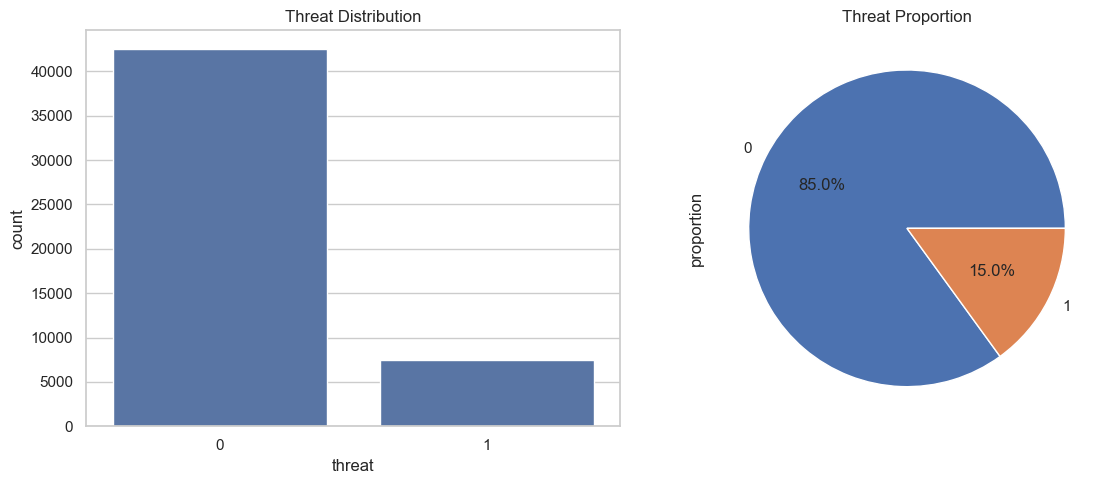

In [ ]:
# 3. Threat Analysis
print("\n    THREAT ANALYSIS   ")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='threat', data=cyber_data)
plt.title('Threat Distribution')

plt.subplot(1, 2, 2)
cyber_data['threat'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
plt.title('Threat Proportion')
plt.tight_layout()
plt.show()


=== FEATURE DISTRIBUTIONS ===


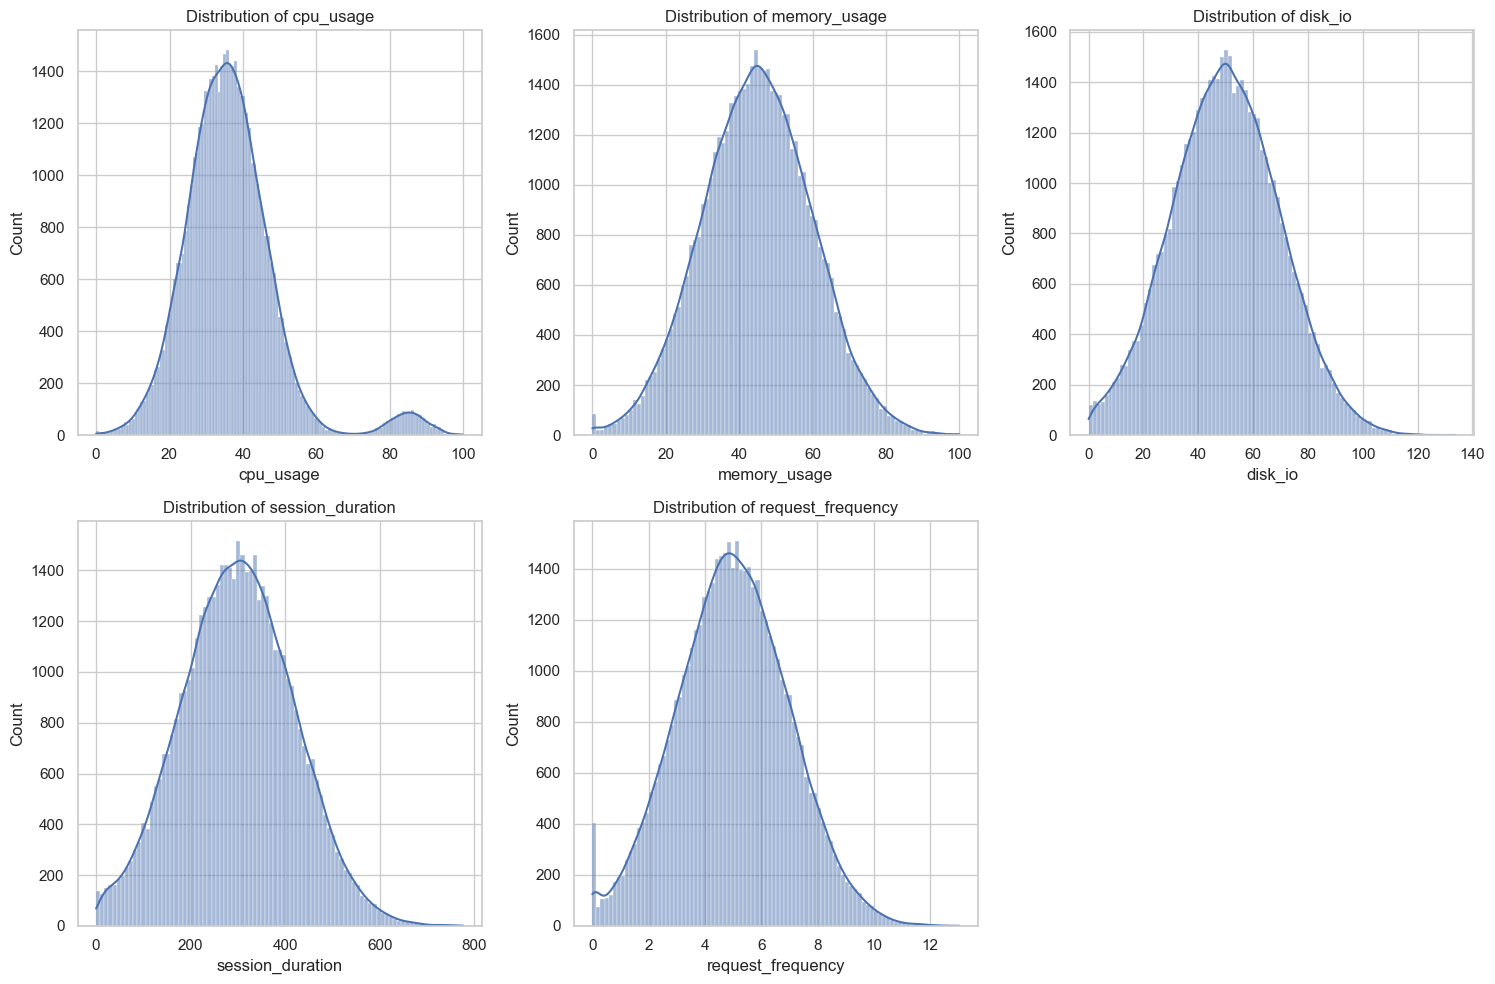

In [ ]:
# 4. Feature Distributions
print("\n  FEATURE DISTRIBUTIONS  ")
numeric_cols = cyber_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = cyber_data.select_dtypes(include=['object']).columns.tolist()

# Plot top 5 numeric features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:5]):
    plt.subplot(2, 3, i+1)
    sns.histplot(cyber_data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

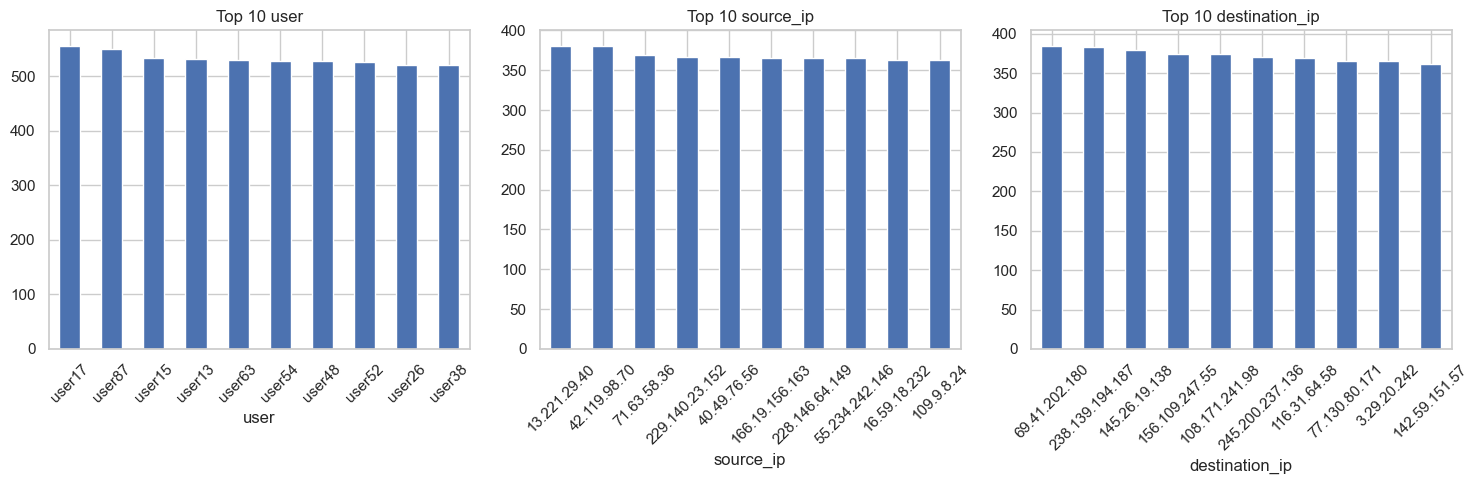

In [37]:
# Plot categorical features
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_cols[:3]):
    plt.subplot(1, 3, i+1)
    cyber_data[col].value_counts().head(10).plot.bar()
    plt.title(f'Top 10 {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


=== THREAT PATTERNS ===


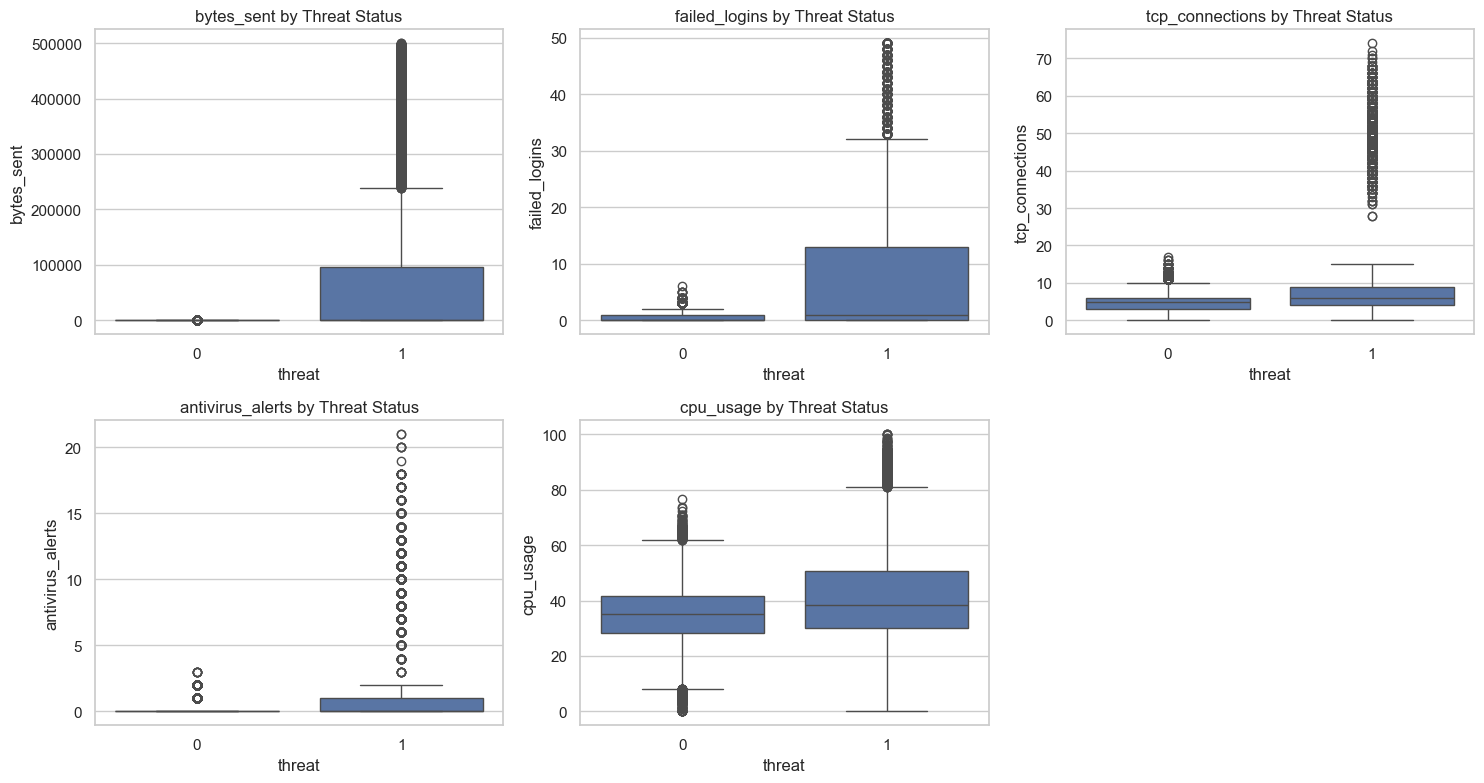

In [ ]:
# 5. Threat Patterns Analysis
print("\n    THREAT PATTERNS    ")
threat_data = cyber_data[cyber_data['threat'] == 1]

plt.figure(figsize=(15, 8))
features_to_compare = ['bytes_sent', 'failed_logins', 'tcp_connections', 'antivirus_alerts', 'cpu_usage']
for i, col in enumerate(features_to_compare):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='threat', y=col, data=cyber_data)
    plt.title(f'{col} by Threat Status')
plt.tight_layout()
plt.show()

In [ ]:

# 3. DATA PREPROCESSING & CLEANING

# Handle missing values (though synthetic data shouldn't have any)
print("\n   Missing Values Check   ")
print(cyber_data.isnull().sum())

# Safely handle timestamp column
if 'timestamp' in cyber_data.columns:
    # Extract time features if needed (hour already exists from generation)
    cyber_data.drop('timestamp', axis=1, inplace=True)
    print("\nDropped 'timestamp' column")
else:
    print("\n'timestamp' column not found - skipping drop")

# Identify feature types
print("\n  Feature Types   ")
numeric_features = cyber_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Safely remove target variable if present
if 'threat' in numeric_features:
    numeric_features.remove('threat')
    print("Target variable 'threat' removed from numeric features")
else:
    print("Warning: 'threat' column not found in numeric features")

categorical_features = ['user', 'source_ip', 'destination_ip', 'device_id', 'protocol', 'auth_method']
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Robust to outliers
    ('scaler', StandardScaler())
])

# Updated OneHotEncoder without sparse parameter
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Removed sparse=False
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("\n   Preprocessing Pipeline Created Successfully   ")


=== Missing Values Check ===
timestamp             0
user                  0
source_ip             0
destination_ip        0
device_id             0
bytes_sent            0
bytes_received        0
packet_count          0
tcp_connections       0
udp_connections       0
cpu_usage             0
memory_usage          0
disk_io               0
process_count         0
failed_logins         0
successful_logins     0
auth_method           0
firewall_blocks       0
antivirus_alerts      0
file_changes          0
protocol              0
port                  0
session_duration      0
request_frequency     0
threat                0
hour                  0
is_working_hours      0
bytes_per_packet      0
login_success_rate    0
dtype: int64

Dropped 'timestamp' column

=== Feature Types ===
Target variable 'threat' removed from numeric features
Numeric features: ['cpu_usage', 'memory_usage', 'disk_io', 'session_duration', 'request_frequency', 'bytes_per_packet', 'login_success_rate']
Categorical f

In [ ]:

# 4. FEATURE ENGINEERING

# Additional feature selection
X = cyber_data.drop('threat', axis=1)
y = cyber_data['threat']

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)
print(f"\nShape after preprocessing: {X_processed.shape}")



Shape after preprocessing: (50000, 488)


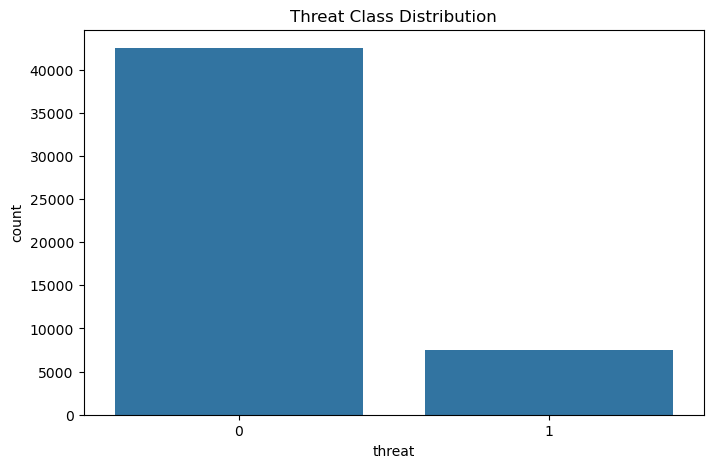

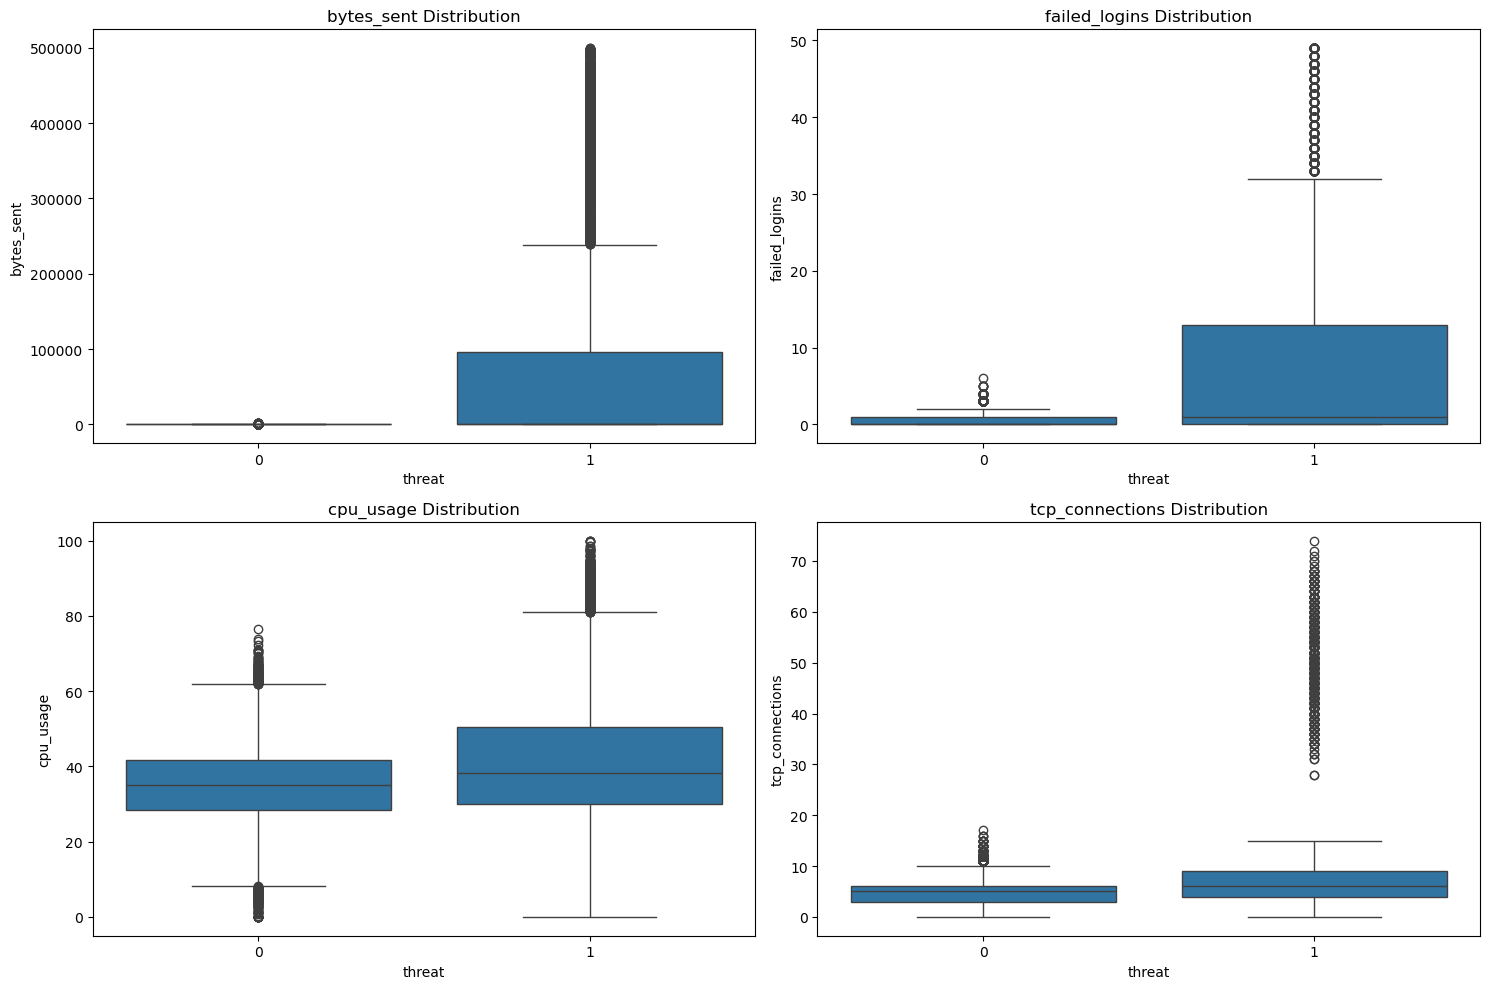

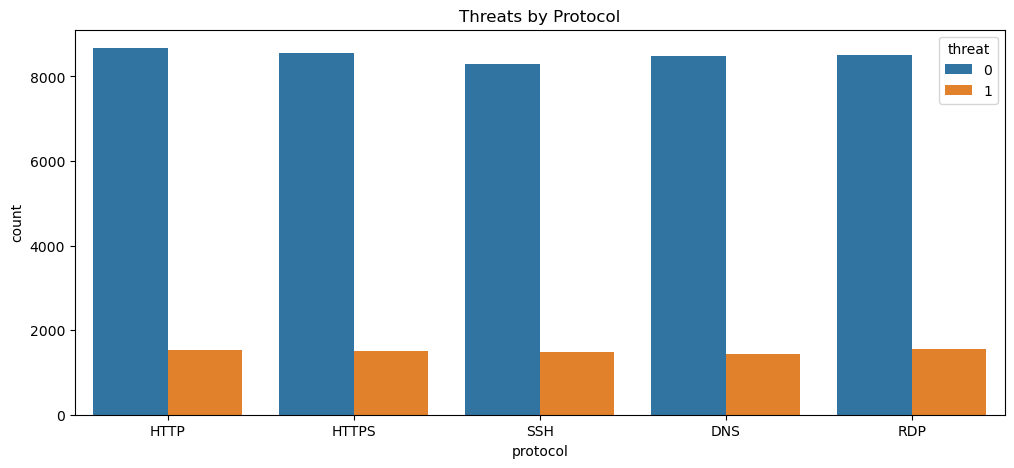

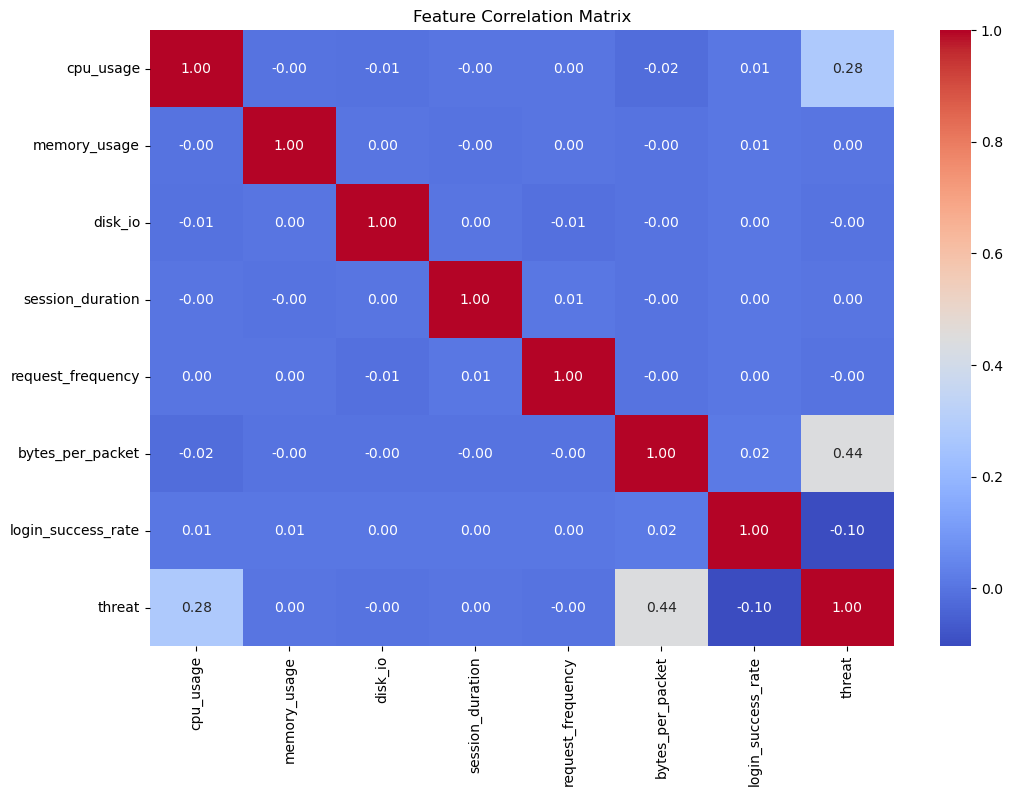

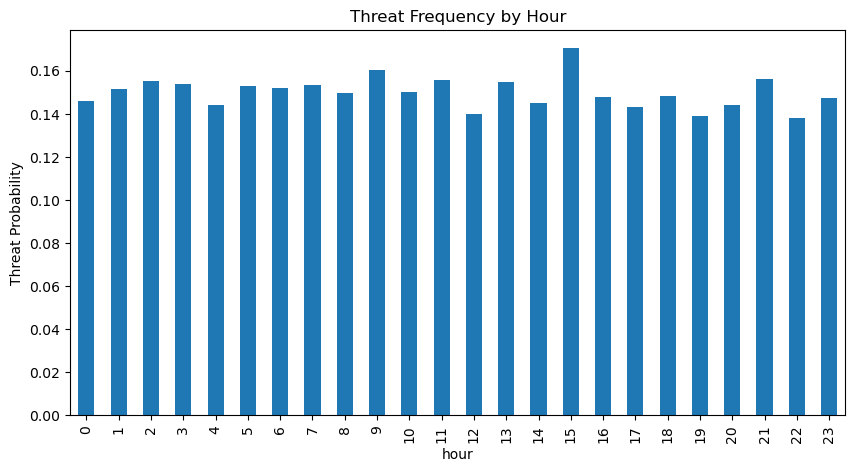

In [ ]:

# 5. DETAILED EDA

def perform_eda(df):
    """Comprehensive Exploratory Data Analysis"""
    
    # 1. Target distribution
    plt.figure(figsize=(8,5))
    sns.countplot(x='threat', data=df)
    plt.title('Threat Class Distribution')
    plt.show()
    
    # 2. Numeric features analysis
    num_cols = ['bytes_sent', 'failed_logins', 'cpu_usage', 'tcp_connections']
    plt.figure(figsize=(15,10))
    for i, col in enumerate(num_cols):
        plt.subplot(2,2,i+1)
        sns.boxplot(x='threat', y=col, data=df)
        plt.title(f'{col} Distribution')
    plt.tight_layout()
    plt.show()
    
    # 3. Categorical analysis
    plt.figure(figsize=(12,5))
    sns.countplot(x='protocol', hue='threat', data=df)
    plt.title('Threats by Protocol')
    plt.show()
    
    # 4. Correlation matrix
    plt.figure(figsize=(12,8))
    corr = df[numeric_features + ['threat']].corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Feature Correlation Matrix')
    plt.show()
    
    # 5. Time patterns
    plt.figure(figsize=(10,5))
    df.groupby('hour')['threat'].mean().plot(kind='bar')
    plt.title('Threat Frequency by Hour')
    plt.ylabel('Threat Probability')
    plt.show()

perform_eda(cyber_data)

In [ ]:

# 6. TRAIN-TEST SPLIT (80-20%)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")


Training samples: 40000
Test samples: 10000


Model Implementation

In [ ]:

# PREPROCESSING 

import time
import scipy.sparse
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Preprocessing pipeline
print("="*60)
print("PREPROCESSING STEP")
print("="*60)
start_preprocess = time.time()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0.8
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Preprocessing completed in {time.time() - start_preprocess:.2f}s")
print("X_train_processed shape:", X_train_processed.shape)
print("="*60)

PREPROCESSING STEP
Preprocessing completed in 0.20s
X_train_processed shape: (40000, 488)


In [ ]:

# 1. LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression

print("\n" + "="*60)
print("TRAINING LOGISTIC REGRESSION")
print("="*60)

start_time = time.time()
logreg = LogisticRegression(
    max_iter=500,
    class_weight='balanced',
    solver='saga',
    n_jobs=-1,
    random_state=42
)

logreg.fit(X_train_processed, y_train)
y_pred = logreg.predict(X_test_processed)
y_proba = logreg.predict_proba(X_test_processed)[:,1]

print("\nRESULTS:")
print(f"Training time: {time.time() - start_time:.2f}s")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save model
import joblib
joblib.dump(logreg, 'logistic_regression_model.joblib')
print("\nModel saved as logistic_regression_model.joblib")
print("="*60)


TRAINING LOGISTIC REGRESSION

RESULTS:
Training time: 1.04s
Accuracy: 0.8135
ROC AUC: 0.8467636862745097

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      8500
           1       0.43      0.72      0.54      1500

    accuracy                           0.81     10000
   macro avg       0.69      0.78      0.71     10000
weighted avg       0.87      0.81      0.83     10000


Model saved as logistic_regression_model.joblib


In [ ]:

# 2. RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier

print("\n" + "="*60)
print("TRAINING RANDOM FOREST")
print("="*60)

start_time = time.time()
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_processed, y_train)
y_pred = rf.predict(X_test_processed)
y_proba = rf.predict_proba(X_test_processed)[:,1]

print("\nRESULTS:")
print(f"Training time: {time.time() - start_time:.2f}s")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(rf, 'random_forest_model.joblib')
print("\nModel saved as random_forest_model.joblib")
print("="*60)


TRAINING RANDOM FOREST

RESULTS:
Training time: 0.94s
Accuracy: 0.8641
ROC AUC: 0.8840547450980392

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.92      8500
           1       0.53      0.81      0.64      1500

    accuracy                           0.86     10000
   macro avg       0.75      0.84      0.78     10000
weighted avg       0.90      0.86      0.88     10000


Model saved as random_forest_model.joblib


In [ ]:

# 3. XGBOOST

from xgboost import XGBClassifier

print("\n" + "="*60)
print("TRAINING XGBOOST")
print("="*60)

start_time = time.time()

# Convert to dense arrays
X_train_xgb = X_train_processed.toarray() if scipy.sparse.issparse(X_train_processed) else X_train_processed
X_test_xgb = X_test_processed.toarray() if scipy.sparse.issparse(X_test_processed) else X_test_processed

xgb = XGBClassifier(
    scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),
    n_estimators=100,
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

xgb.fit(X_train_xgb, y_train)
y_pred = xgb.predict(X_test_xgb)
y_proba = xgb.predict_proba(X_test_xgb)[:,1]

print("\nRESULTS:")
print(f"Training time: {time.time() - start_time:.2f}s")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(xgb, 'xgboost_model.joblib')
print("\nModel saved as xgboost_model.joblib")
print("="*60)


TRAINING XGBOOST

RESULTS:
Training time: 0.97s
Accuracy: 0.9218
ROC AUC: 0.8794712156862744

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      8500
           1       0.75      0.71      0.73      1500

    accuracy                           0.92     10000
   macro avg       0.85      0.83      0.84     10000
weighted avg       0.92      0.92      0.92     10000


Model saved as xgboost_model.joblib


In [ ]:

# 4. NEURAL NETWORK

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("\n" + "="*60)
print("TRAINING NEURAL NETWORK")
print("="*60)

start_time = time.time()

# Convert to dense arrays
X_train_nn = X_train_processed.toarray() if scipy.sparse.issparse(X_train_processed) else X_train_processed
X_test_nn = X_test_processed.toarray() if scipy.sparse.issparse(X_test_processed) else X_test_processed

# Model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_nn, y_train,
    validation_data=(X_test_nn, y_test),
    epochs=15,
    batch_size=256,
    callbacks=[EarlyStopping(patience=2)],
    verbose=1
)

y_pred = (model.predict(X_test_nn) > 0.5).astype(int)
y_proba = model.predict(X_test_nn).flatten()

print("\nRESULTS:")
print(f"Training time: {time.time() - start_time:.2f}s")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

model.save('neural_network_model.h5')
print("\nModel saved as neural_network_model.h5")
print("="*60)


TRAINING NEURAL NETWORK
Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8907 - loss: 0.3013 - val_accuracy: 0.9186 - val_loss: 0.2666
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9225 - loss: 0.2193 - val_accuracy: 0.9192 - val_loss: 0.2366
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9238 - loss: 0.2080 - val_accuracy: 0.9196 - val_loss: 0.2386
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9242 - loss: 0.2009 - val_accuracy: 0.9198 - val_loss: 0.2475
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step



RESULTS:
Training time: 4.79s
Accuracy: 0.9198
ROC AUC: 0.8653616470588235

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.95      8500
           1       0.98      0.48      0.64      1500

    accuracy                           0.92     10000
   macro avg       0.95      0.74      0.80     10000
weighted avg       0.92      0.92      0.91     10000


Model saved as neural_network_model.h5


In [ ]:

# 4. KNN

from sklearn.neighbors import KNeighborsClassifier

print("\n" + "="*60)
print("TRAINING KNN")
print("="*60)

start_time = time.time()

# Convert to dense arrays (KNN typically requires dense data)
X_train_knn = X_train_processed.toarray() if scipy.sparse.issparse(X_train_processed) else X_train_processed
X_test_knn = X_test_processed.toarray() if scipy.sparse.issparse(X_test_processed) else X_test_processed

# Initialize KNN classifier
knn = KNeighborsClassifier(
    n_neighbors=5,  # Default value, you might want to tune this
    weights='uniform',  # or 'distance'
    algorithm='auto',  # auto-selects the best algorithm
    n_jobs=-1  # use all processors
)

knn.fit(X_train_knn, y_train)
y_pred = knn.predict(X_test_knn)
y_proba = knn.predict_proba(X_test_knn)[:,1]  # Probability estimates for positive class

print("\nRESULTS:")
print(f"Training time: {time.time() - start_time:.2f}s")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(knn, 'knn_model.joblib')
print("\nModel saved as knn_model.joblib")
print("="*60)


TRAINING KNN

RESULTS:
Training time: 5.82s
Accuracy: 0.9022
ROC AUC: 0.8164933333333334

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      8500
           1       0.79      0.48      0.59      1500

    accuracy                           0.90     10000
   macro avg       0.85      0.73      0.77     10000
weighted avg       0.89      0.90      0.89     10000


Model saved as knn_model.joblib


In [ ]:

# MODEL COMPARISON

import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, roc_auc_score

print("="*60)
print("MODEL COMPARISON")
print("="*60)

# Load all saved models
models = {
    "Logistic Regression": joblib.load('logistic_regression_model.joblib'),
    "Random Forest": joblib.load('random_forest_model.joblib'),
    "XGBoost": joblib.load('xgboost_model.joblib'),
    "KNN": joblib.load('knn_model.joblib'),
    "Neural Network": load_model('neural_network_model.h5')
}

# Prepare comparison table
results = []

for name, model in models.items():
    if name == "Neural Network":
        # Special handling for NN
        X_test_nn = X_test_processed.toarray() if scipy.sparse.issparse(X_test_processed) else X_test_processed
        y_pred = (model.predict(X_test_nn) > 0.5).astype(int)
        y_proba = model.predict(X_test_nn).flatten()
    elif name in ["XGBoost", "KNN"]:
        # Convert to dense for XGBoost and KNN
        X_test_dense = X_test_processed.toarray() if scipy.sparse.issparse(X_test_processed) else X_test_processed
        y_pred = model.predict(X_test_dense)
        y_proba = model.predict_proba(X_test_dense)[:,1]
    else:
        # For other sklearn models
        y_pred = model.predict(X_test_processed)
        y_proba = model.predict_proba(X_test_processed)[:,1]
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'Precision (Threat)': classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
        'Recall (Threat)': classification_report(y_test, y_pred, output_dict=True)['1']['recall'],
        'F1 (Threat)': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
    })

# Create and display comparison dataframe
comparison_df = pd.DataFrame(results).sort_values('ROC AUC', ascending=False)
pd.set_option('display.float_format', '{:.4f}'.format)
print("\nModel Performance Comparison:")
print(comparison_df)

# Highlight best in each category
print("\nBest Models by Metric:")
print("-"*40)
print(f"Highest Accuracy: {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']} ({comparison_df['Accuracy'].max():.4f})")
print(f"Highest ROC AUC: {comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Model']} ({comparison_df['ROC AUC'].max():.4f})")
print(f"Highest Threat Precision: {comparison_df.loc[comparison_df['Precision (Threat)'].idxmax(), 'Model']} ({comparison_df['Precision (Threat)'].max():.4f})")
print(f"Highest Threat Recall: {comparison_df.loc[comparison_df['Recall (Threat)'].idxmax(), 'Model']} ({comparison_df['Recall (Threat)'].max():.4f})")
print(f"Highest Threat F1: {comparison_df.loc[comparison_df['F1 (Threat)'].idxmax(), 'Model']} ({comparison_df['F1 (Threat)'].max():.4f})")
print("="*60)

MODEL COMPARISON


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step

Model Performance Comparison:
                 Model  Accuracy  ROC AUC  Precision (Threat)  Recall (Threat)  F1 (Threat)
1        Random Forest    0.8641   0.8841              0.5306           0.8140       0.6425
2              XGBoost    0.9218   0.8795              0.7539           0.7107       0.7316
4       Neural Network    0.9198   0.8654              0.9794           0.4753       0.6400
0  Logistic Regression    0.8135   0.8468              0.4280           0.7227       0.5376
3                  KNN    0.9022   0.8165              0.7862           0.4780       0.5945

Best Models by Metric:
----------------------------------------
Highest Accuracy: XGBoost (0.9218)
Highest ROC AUC: Random Forest (0.8841)
Highest Threat Precision: Neural Network (0.9794)
Highest Threat Recall: Random Forest (0.8140)
Highest Threat F1: XGBoost (0.7316)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print(comparison_df)

                 Model  Accuracy  ROC AUC  Precision (Threat)  Recall (Threat)  F1 (Threat)
1        Random Forest    0.8641   0.8841              0.5306           0.8140       0.6425
2              XGBoost    0.9218   0.8795              0.7539           0.7107       0.7316
4       Neural Network    0.9198   0.8654              0.9794           0.4753       0.6400
0  Logistic Regression    0.8135   0.8468              0.4280           0.7227       0.5376
3                  KNN    0.9022   0.8165              0.7862           0.4780       0.5945


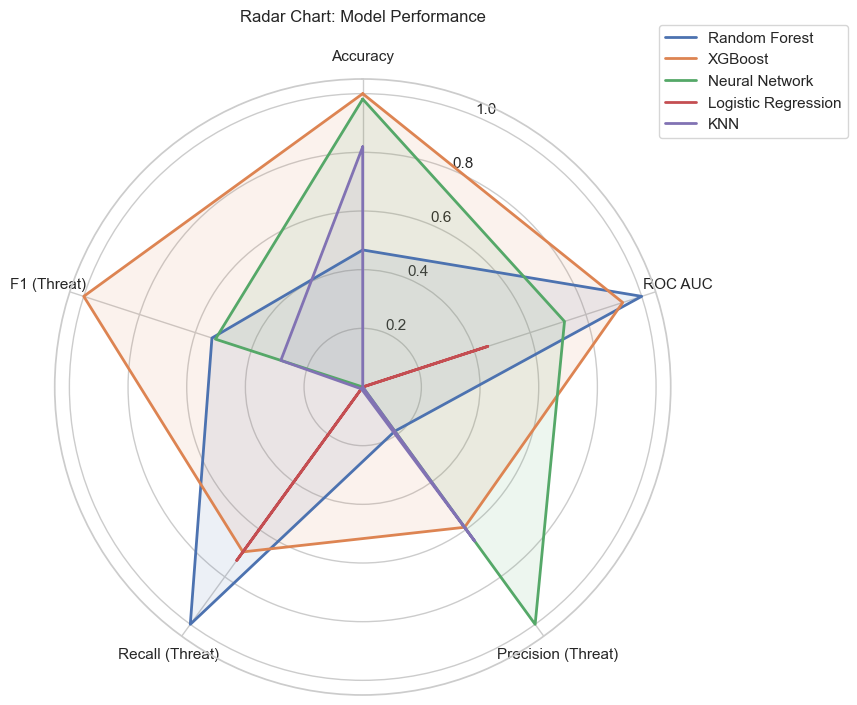

In [22]:
# Metrics to include
metrics = ['Accuracy', 'ROC AUC', 'Precision (Threat)', 'Recall (Threat)', 'F1 (Threat)']
num_vars = len(metrics)

# Normalize data to 0-1 scale for radar chart
normalized_df = comparison_df.copy()
for col in metrics:
    normalized_df[col] = (comparison_df[col] - comparison_df[col].min()) / \
                         (comparison_df[col].max() - comparison_df[col].min())

# Compute angles for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)

for idx, row in normalized_df.iterrows():
    values = row[metrics].values.tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, label=row['Model'], linewidth=2)
    ax.fill(angles, values, alpha=0.1)

# Formatting
ax.set_theta_offset(np.pi / 2)  # Start at top
ax.set_theta_direction(-1)      # Clockwise
ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
plt.title('Radar Chart: Model Performance', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

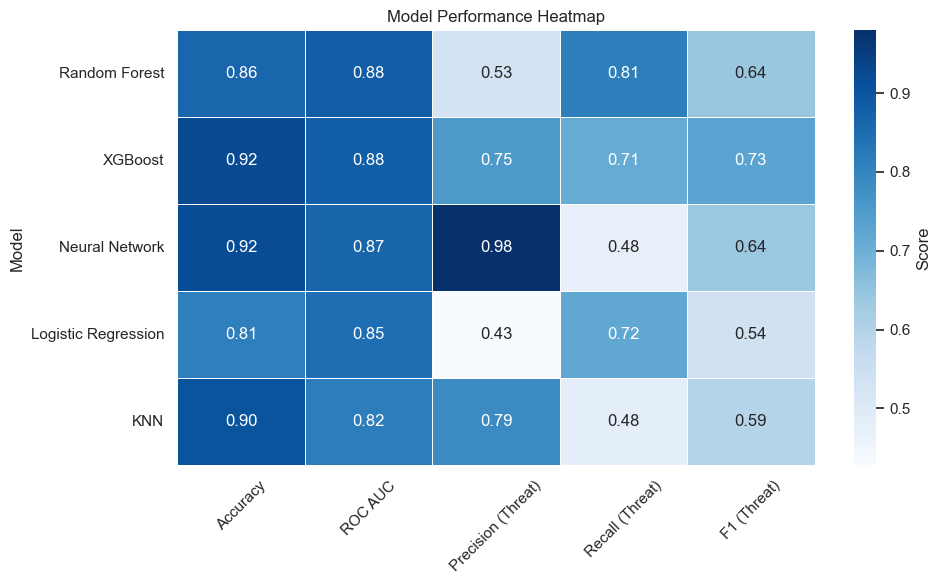

In [23]:
plt.figure(figsize=(10, 6))
heatmap_data = comparison_df.set_index('Model')[metrics]
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='Blues', 
            cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title('Model Performance Heatmap')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

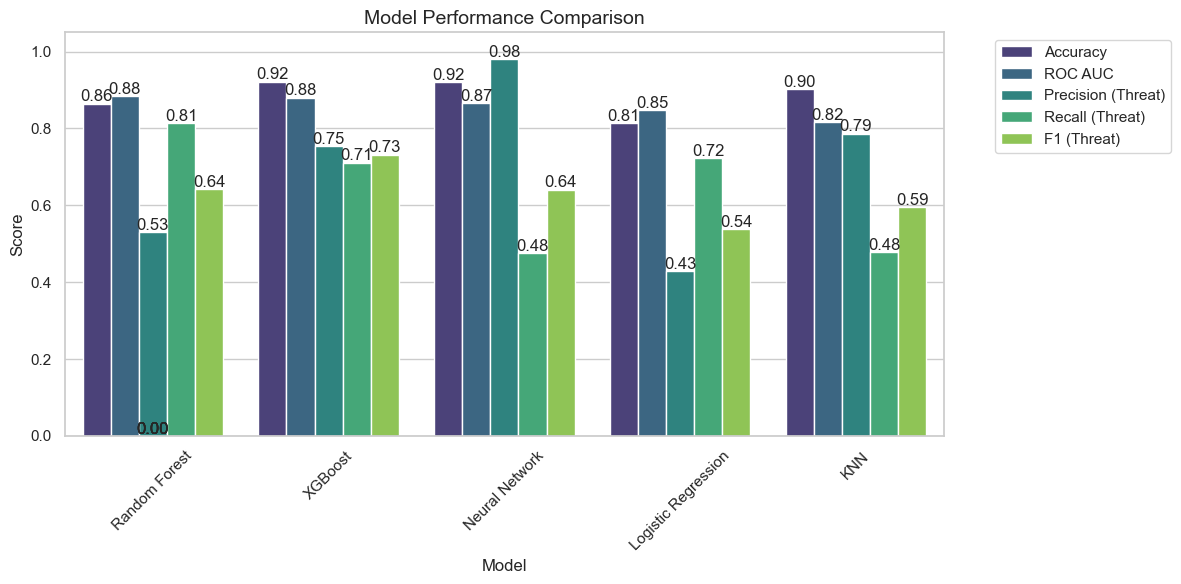

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Melt dataframe for easier plotting
melted_df = comparison_df.melt(id_vars="Model", 
                              value_vars=['Accuracy', 'ROC AUC', 'Precision (Threat)', 
                                          'Recall (Threat)', 'F1 (Threat)'],
                              var_name="Metric", 
                              value_name="Score")

# Plot
ax = sns.barplot(x="Model", y="Score", hue="Metric", 
                 data=melted_df, palette="viridis")
plt.title("Model Performance Comparison", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:

# 9. LSTM IMPLEMENTATION 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Prepare sequences for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train['user'] + " " + X_train['device_id'] + " " + X_train['protocol'])
X_train_seq = tokenizer.texts_to_sequences(X_train['user'] + " " + X_train['device_id'] + " " + X_train['protocol'])
X_test_seq = tokenizer.texts_to_sequences(X_test['user'] + " " + X_test['device_id'] + " " + X_test['protocol'])

max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# LSTM model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

# Train LSTM
history = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=20,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

# Evaluate LSTM
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype(int)
print("\nLSTM Performance:")
print(classification_report(y_test, y_pred_lstm))

# Create comparison entry
lstm_metrics = {
    'Model': 'LSTM',
    'Accuracy': accuracy_score(y_test, y_pred_lstm),
    'ROC AUC': roc_auc_score(y_test, lstm_model.predict(X_test_pad).flatten()),
    'Precision (Threat)': precision_score(y_test, y_pred_lstm),
    'Recall (Threat)': recall_score(y_test, y_pred_lstm)
}


# 10. SAVE MODELS 

# Save LSTM model
lstm_model.save('lstm_cyber_threat_model.h5')
print("Saved LSTM model as lstm_cyber_threat_model.h5")

# If you have other models to save:
# joblib.dump(model, 'model_name.joblib')

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8356 - loss: 0.4453 - val_accuracy: 0.8500 - val_loss: 0.4227
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.8496 - loss: 0.4238 - val_accuracy: 0.8500 - val_loss: 0.4227
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.8496 - loss: 0.4238 - val_accuracy: 0.8500 - val_loss: 0.4227
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.8496 - loss: 0.4238 - val_accuracy: 0.8500 - val_loss: 0.4227
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.8496 - loss: 0.4237 - val_accuracy: 0.8500 - val_loss: 0.4227
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

LSTM Performance:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8500
           1       0.00      0.00      0.00      1500

    accuracy                           0.85     10000
   macro avg       0.42      0.50      0.46     10000
weighted avg      

Saved LSTM model as lstm_cyber_threat_model.h5
